In [182]:
import yfinance as yf
import numpy as np
import pandas as pd
from ripser import Rips
import persim
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [183]:
# Define a list of tickers
# tickers = ['^GSPC']
# tickers = ['^GSPC', '^DJI', '^IXIC', '^RUT']

In [184]:
# Set the end date to today
# end_date = datetime.today()
end_date = '2014-01-06'

In [185]:
# Set the start date from 2 years ago
# start_date = end_date - timedelta(days=2*365)
# print(start_date)
start_date = '2006-01-01'

In [186]:
# Pull data into a empty dataframe
df = pd.DataFrame()

# for ticker in tickers:
#     raw_data = yf.download(ticker, start=start_date, end=end_date)
#     df = raw_data

SP500 = yf.Ticker("^DJI")
raw_data = SP500.history(period="max", start=start_date, end=end_date)
df = raw_data

In [187]:
# Checking to see if there is any missing data
df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [188]:
# Fetching only adjacent close price
df_close = df['Close'] # Becease adj. close price considers other factors like dividends, stock splits and new stock offering.
print(len(df_close))
df_close = df_close.to_frame()
df_close

2015


,Close
Date,
2006-01-03 00:00:00-05:00,10847.410156
2006-01-04 00:00:00-05:00,10880.150391
2006-01-05 00:00:00-05:00,10882.150391
2006-01-06 00:00:00-05:00,10959.309570
2006-01-09 00:00:00-05:00,11011.900391
...,...
2013-12-27 00:00:00-05:00,16478.410156
2013-12-30 00:00:00-05:00,16504.289062
2013-12-31 00:00:00-05:00,16576.660156


In [189]:
# Define array of adjusted closing prices
P = df_close.to_numpy()
# Define array of log-returns defined as the log of the ratio between closing values of two subsequent days
r = np.log(np.divide(P[1:],P[:len(P)-1]))

In [190]:
# Instantiate Vietoris-Rips solver
rips = Rips(maxdim=2)

# some parameters
w = 20 # time window size
n = len(raw_data)-(2*w)+1 # number of time segments
wasserstein_dists = np.zeros((n,1)) # initialize array for wasserstein distances

# compute wasserstein distances between persitence diagrams for subsequent time windows
for i in range(n):
    # Compute persistence diagrams for adjacent time windows
    dgm1 = rips.fit_transform(r[i:i+w])
    dgm2 = rips.fit_transform(r[i+w+1:i+(2*w)+1])
    # Compute wasserstein distance between diagrams
    wasserstein_dists[i] = persim.wasserstein(dgm1[0], dgm2[0], matching=False)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [191]:
len(raw_data)

2015

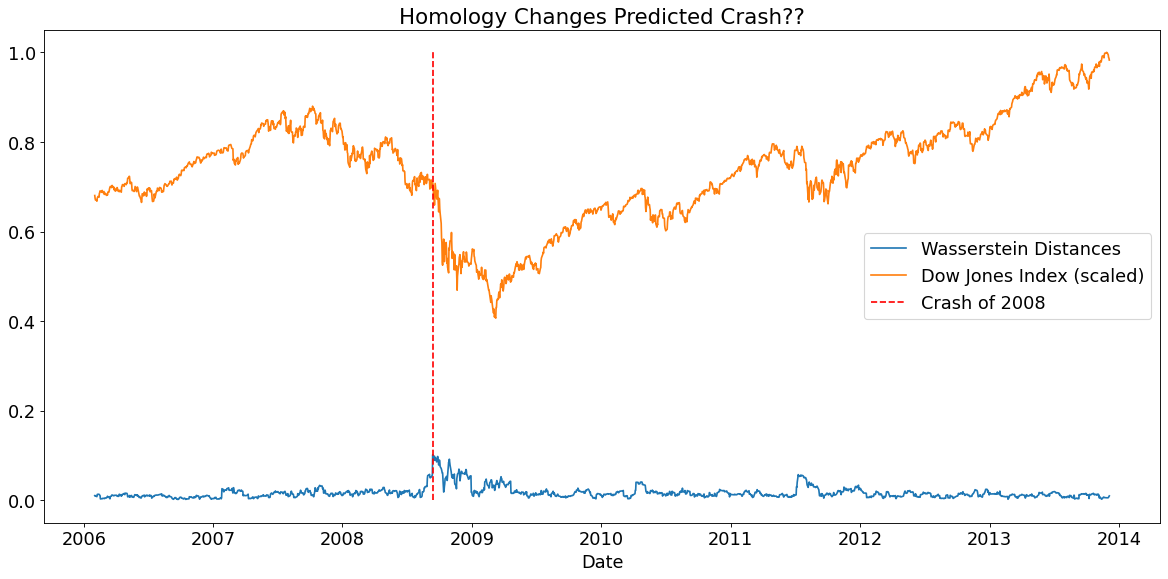

In [192]:
# Plot wasserstein distances over time
plt.figure(figsize=(18, 8), dpi=80)
plt.rcParams.update({'font.size': 16})

plt.plot(raw_data.index[w:n+w], wasserstein_dists)
plt.plot(raw_data.index[w:n+w], df_close.iloc[w:n+w,0]/max(df_close.iloc[w:n+w,0]))
# plt.plot([raw_data.index[501], raw_data.index[501]], [0, 1], 'r--')
plt.plot([raw_data.index[678], raw_data.index[678]], [0, 1], 'r--')
plt.legend(['Wasserstein Distances', 'Dow Jones Index (scaled)', 'Crash of 2008'])
plt.xlabel('Date')
plt.title('Homology Changes Predicted Crash??')
plt.show()

# plt.savefig('Homology_example.png', dpi='figure', format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')